In [1]:
import Hokusai
import PyPlot

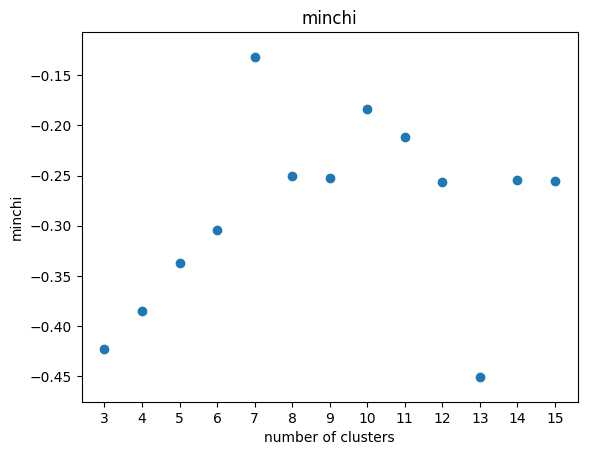

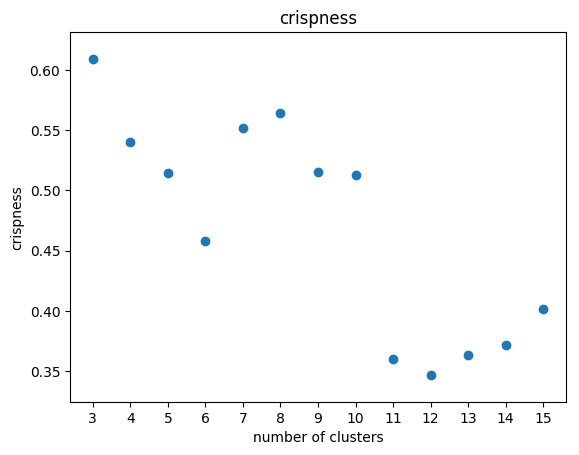

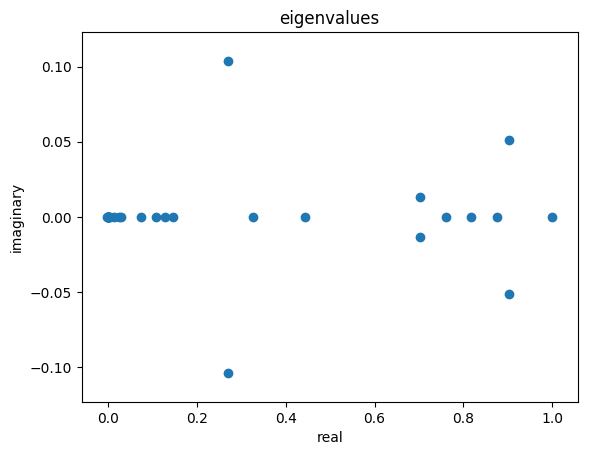

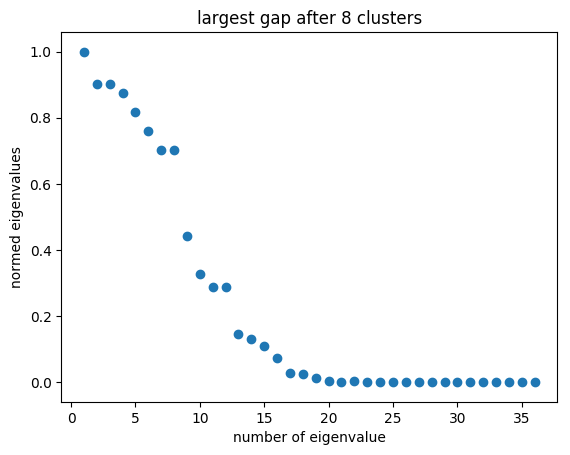

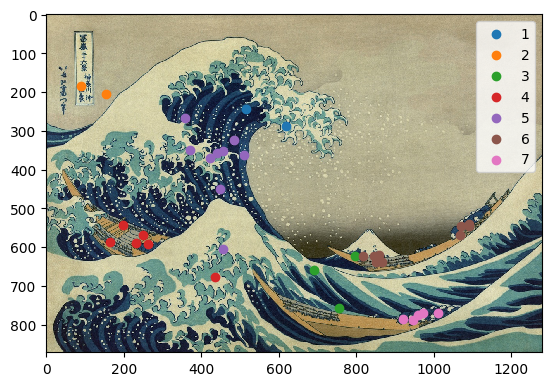

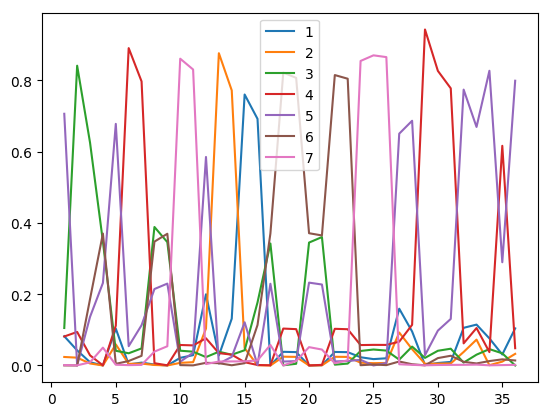

eigenvector gap: [8, 12, 9, 1, 4]
minchi: [7.0, 10.0, 11.0, 8.0, 9.0, 14.0, 15.0, 12.0, 6.0, 5.0, 4.0, 3.0, 13.0]
crispness: [3.0, 8.0, 7.0, 4.0, 9.0, 5.0, 10.0, 6.0, 15.0, 14.0, 13.0, 11.0, 12.0]


In [8]:
# compare criterions
image = 8
person = 7
sigma = 50
tau = 60
symmetrize = false #reversible MC?
ratematrix = false #select highest/lowest eigenvalue
# possible number of clusters
kmin = 3
kmax = 15

data = Hokusai.filterdata(Hokusai.DATA, image)
ts = Hokusai.TimeSeries(data)

timeseries = person == 0 ? ts : ts[person]

# get transition matrix
grid = Hokusai.points(timeseries)
P = Hokusai.transitionmatrix(timeseries, sigma, tau, grid, symmetrize)
# get stationary distribution
pi = Hokusai.stationaryDistr(P, ratematrix)

S = schurfact(P)
real = [x.re for x in S[:values]]
imaginary = [x.im for x in S[:values]]
distances = sqrt.(real.^2 .+ imaginary.^2)
d = [distances[i-1] - distances[i] for i = 2:length(distances)]
maxgaps = sortperm(d,rev=true)[1:5]

crisp = zeros(kmax - kmin + 1, 2)
minchi = zeros(kmax - kmin + 1, 2)
for k = kmin:kmax
    #println(k," clusters")
    # schurfactorization
    X, λ = Hokusai.schurvectors(P, pi, k, ratematrix)
    # compute A via prechosen fct obj
    A = Hokusai.guessinit(X)
    chi = X*A
    #println("minChi: ",findmin(chi))
    minchi[k - kmin + 1, 2] = findmin(chi)[1]
    minchi[k - kmin + 1, 1] = k
    A = Hokusai.opt(A, X, A -> Hokusai.I3(A))
    # trace(S)/k
    crisp[k - kmin + 1, 2] = Hokusai.I3(A)/k
    crisp[k - kmin + 1, 1] = k
end
PyPlot.figure()
PyPlot.scatter(minchi[:,1], minchi[:,2])
PyPlot.xlabel("number of clusters")
PyPlot.ylabel("minchi")
PyPlot.xticks(minchi[:,1])
PyPlot.title("minchi")

PyPlot.figure()
PyPlot.scatter(crisp[:,1], crisp[:,2])
PyPlot.xlabel("number of clusters")
PyPlot.xticks(crisp[:,1])
PyPlot.ylabel("crispness")
PyPlot.title("crispness")

PyPlot.figure()
PyPlot.scatter(real, imaginary)
PyPlot.title("eigenvalues")
PyPlot.xlabel("real")
PyPlot.ylabel("imaginary")

PyPlot.figure()
PyPlot.scatter(collect(1:length(distances)), distances)
PyPlot.title(string("largest gap after ",findmax(d)[2]," clusters"))
PyPlot.ylabel("normed eigenvalues")
PyPlot.xlabel("number of eigenvalue")

noCluster = findmax(minchi[:,2])[2]+kmin-1
#findmax(d)[2]

ass, chi = Hokusai.run(timeseries, noCluster, sigma, tau)
Hokusai.plotimg(image)
# plot memership vectors
N,k = size(chi)
PyPlot.figure()
for i = 1:k
    PyPlot.plot(1:N,chi[:,i], label = i)
    PyPlot.legend()
end
println(string("eigenvector gap: ", maxgaps))
println(string("minchi: ", minchi[sortperm(minchi[:,2],rev=true),1]))
println(string("crispness: ", crisp[sortperm(crisp[:,2],rev=true),1]))

maximal gaps: [1, 7, 14, 8, 2]
maximal minchis: [7, 9, 8, 12, 14, 13, 11, 10]
posssible clusters: [7, 9, 14]
crispness criterion: [7.0 0.375914; 9.0 0.279119; 14.0 0.146466]
final number of clusters: 7


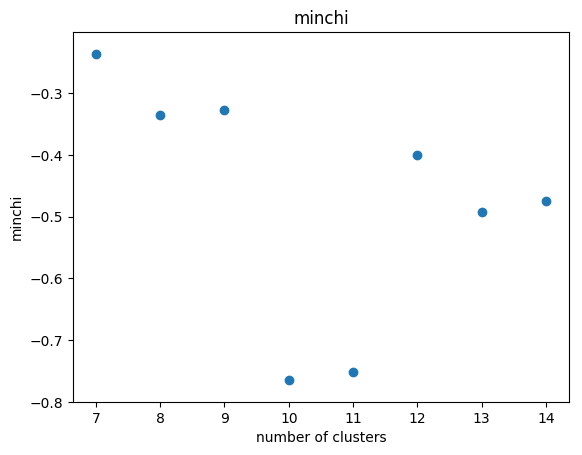

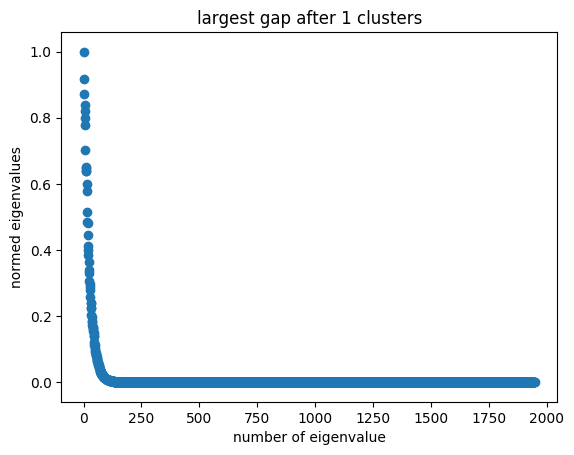

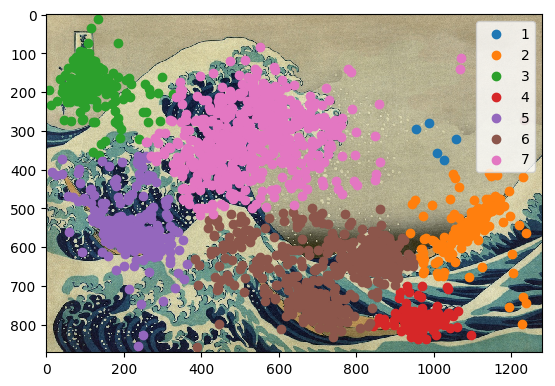

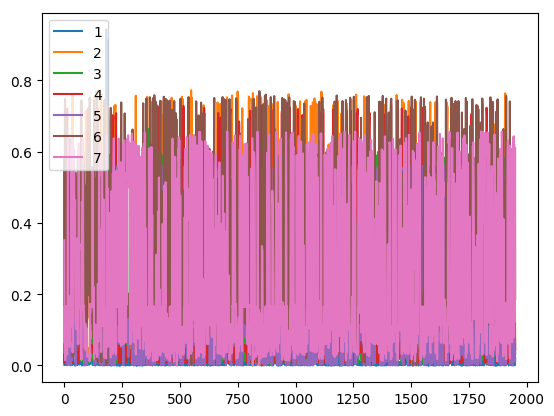

eigenvector gap: [7, 14, 8]
minchi: [7.0, 9.0, 8.0, 12.0, 14.0, 13.0, 11.0, 10.0]
crispness: [7.0, 9.0, 14.0]


In [20]:
# automatic number
image = 8
person = 0
sigma = 50
tau = 60
symmetrize = false #reversible MC?
ratematrix = false #select highest/lowest eigenvalue

data = Hokusai.filterdata(Hokusai.DATA, image)
ts = Hokusai.TimeSeries(data)

timeseries = person == 0 ? ts : ts[person]

# get transition matrix
grid = Hokusai.points(timeseries)
P = Hokusai.transitionmatrix(timeseries, sigma, tau, grid, symmetrize)
# get stationary distribution
pi = Hokusai.stationaryDistr(P, ratematrix)

S = schurfact(P)
real = [x.re for x in S[:values]]
imaginary = [x.im for x in S[:values]]
distances = sqrt.(real.^2 .+ imaginary.^2)
d = [distances[i-1] - distances[i] for i = 2:length(distances)]
maxgaps = sortperm(d,rev=true)[1:5]
println(string("maximal gaps: ",maxgaps))

# algorithm is not working for number of clusters <= 2
deleteat!(maxgaps,findin(maxgaps,[1,2])) 
kmin = minimum(maxgaps[1:3])
kmax = maximum(maxgaps[1:3])

minchi = zeros(kmax - kmin + 1, 2)
for k = kmin:kmax
    # schurfactorization
    X, λ = Hokusai.schurvectors(P, pi, k, ratematrix)
    A = Hokusai.guessinit(X)
    chi = X*A
    minchi[k - kmin + 1, 2] = findmin(chi)[1]
    minchi[k - kmin + 1, 1] = k
end
maxminchi = trunc.(Int,minchi[sortperm(minchi[:,2],rev=true),1])
println(string("maximal minchis: ",maxminchi))
possiblecluster = union(maxminchi[1:2],maxgaps[1:2])
println(string("posssible clusters: ",possiblecluster))

crisp = zeros(length(possiblecluster), 2)
i = 1
for k in possiblecluster
    # schurfactorization
    X, λ = Hokusai.schurvectors(P, pi, k, ratematrix)
    A = Hokusai.guessinit(X)
    A = Hokusai.opt(A, X, A -> Hokusai.I3(A))
    # trace(S)/k
    crisp[i, 2] = Hokusai.I3(A)/k
    crisp[i, 1] = k
    i += 1
end
println(string("crispness criterion: ",crisp))

PyPlot.figure()
PyPlot.scatter(minchi[:,1], minchi[:,2])
PyPlot.xlabel("number of clusters")
PyPlot.ylabel("minchi")
PyPlot.xticks(minchi[:,1])
PyPlot.title("minchi")

PyPlot.figure()
PyPlot.scatter(collect(1:length(distances)), distances)
PyPlot.title(string("largest gap after ",findmax(d)[2]," clusters"))
PyPlot.ylabel("normed eigenvalues")
PyPlot.xlabel("number of eigenvalue")

noCluster = Int(crisp[findmax(crisp[:,2])[2],1])
println(string("final number of clusters: ",noCluster))

ass, chi = Hokusai.run(timeseries, noCluster, sigma, tau)
Hokusai.plotimg(image)
# plot memership vectors
N,k = size(chi)
PyPlot.figure()
for i = 1:k
    PyPlot.plot(1:N,chi[:,i], label = i)
    PyPlot.legend()
end
println(string("eigenvector gap: ", maxgaps))
println(string("minchi: ", minchi[sortperm(minchi[:,2],rev=true),1]))
println(string("crispness: ", crisp[sortperm(crisp[:,2],rev=true),1]))

3-element Array{Int64,1}:
 1
 3
 1